# Метрика для оценки разницы между спектрограммами

In [1]:
import sys
sys.path.append('..')

from functools import reduce

import numpy as np
from scipy import signal

from seismicpro.batchflow import Dataset
from seismicpro.src import SeismicBatch, FieldIndex, seismic_plot

from utils import get_cv, draw_modifications_dist

### Процедура получения метрики

**Расстояние между двумя спектрограммами** с равным количеством трасс и отсчетов будем вычислять по следующей процедуре

* Выбрать область из 10% трасс с наименьшим офсетом, ограничить вычисления только в этой области
* Получить спектральную плотность мощности с помощью оконного преобразования Фурье для каждой трассы для обеих спектрограмм
* Для соответствующих значений сдвигов окна по времени и соответсвующих трасс вычислить разницу спектров в разных спектрограммах по формуле
$$
Dist(A_1, A_2) = \sum_{f}\left|{A_{1}[f]-A_{2}[f]}\right|
$$
* Усреднить полученные значения по всем трассам и всем сдвигам окна по времени

![Seismogram difference metrics](Seismogram_difference_metrics.png)

In [2]:
base_path = '/home/antonina/winhome/datasets/synthetic_4_metrics_study/'
      
paths = dict(ideal = 'SurfWave_G03_Reflection.sgy',
            noise = 'SurfWave_G03_DirectAndNoise.sgy',
            full = 'SurfWave_G03_FullWaveField.sgy')


## Загружаем и изучаем данные 

In [3]:
fi1 = FieldIndex(name='ideal', path=base_path+paths['ideal'], extra_headers=['offset'])
fi2 = FieldIndex(name='noise', path=base_path+paths['noise'], extra_headers=['offset'])
fi2._idf['TraceNumber'] = fi2._idf['TraceNumber'] - 1
fi2._idf['TRACE_SEQUENCE_FILE'] = fi2._idf['TRACE_SEQUENCE_FILE'] - 1
fi3 = FieldIndex(name='full', path=base_path+paths['full'], extra_headers=['offset'])

In [4]:
field_index = reduce(lambda x, y: x.merge(y), (fi1, fi2, fi3))

len(field_index)

1

In [5]:
field_index._idf['offset'] = field_index._idf['offset'].abs()
field_index.head()

,TraceNumber,offset,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,ideal,ideal,noise,noise,full,full
FieldRecord,,,,,,,,
1,1,2447,1,/home/antonina/winhome/datasets/synthetic_4_me...,1,/home/antonina/winhome/datasets/synthetic_4_me...,1,/home/antonina/winhome/datasets/synthetic_4_me...
1,2,2397,2,/home/antonina/winhome/datasets/synthetic_4_me...,2,/home/antonina/winhome/datasets/synthetic_4_me...,2,/home/antonina/winhome/datasets/synthetic_4_me...
1,3,2347,3,/home/antonina/winhome/datasets/synthetic_4_me...,3,/home/antonina/winhome/datasets/synthetic_4_me...,3,/home/antonina/winhome/datasets/synthetic_4_me...
1,4,2297,4,/home/antonina/winhome/datasets/synthetic_4_me...,4,/home/antonina/winhome/datasets/synthetic_4_me...,4,/home/antonina/winhome/datasets/synthetic_4_me...
1,5,2247,5,/home/antonina/winhome/datasets/synthetic_4_me...,5,/home/antonina/winhome/datasets/synthetic_4_me...,5,/home/antonina/winhome/datasets/synthetic_4_me...


In [6]:
fidf = field_index.get_df()

batch = (Dataset(field_index, SeismicBatch).next_batch(1)
         .load(fmt='segy', components=tuple(paths.keys()))
         .sort_traces(src=('ideal', 'noise', 'full'), dst=('ideal', 'noise', 'full'), 
                      sort_by='offset'))

In [7]:
ideal, noise, full = batch.ideal[0], batch.noise[0], batch.full[0]

cv = get_cv([ideal])

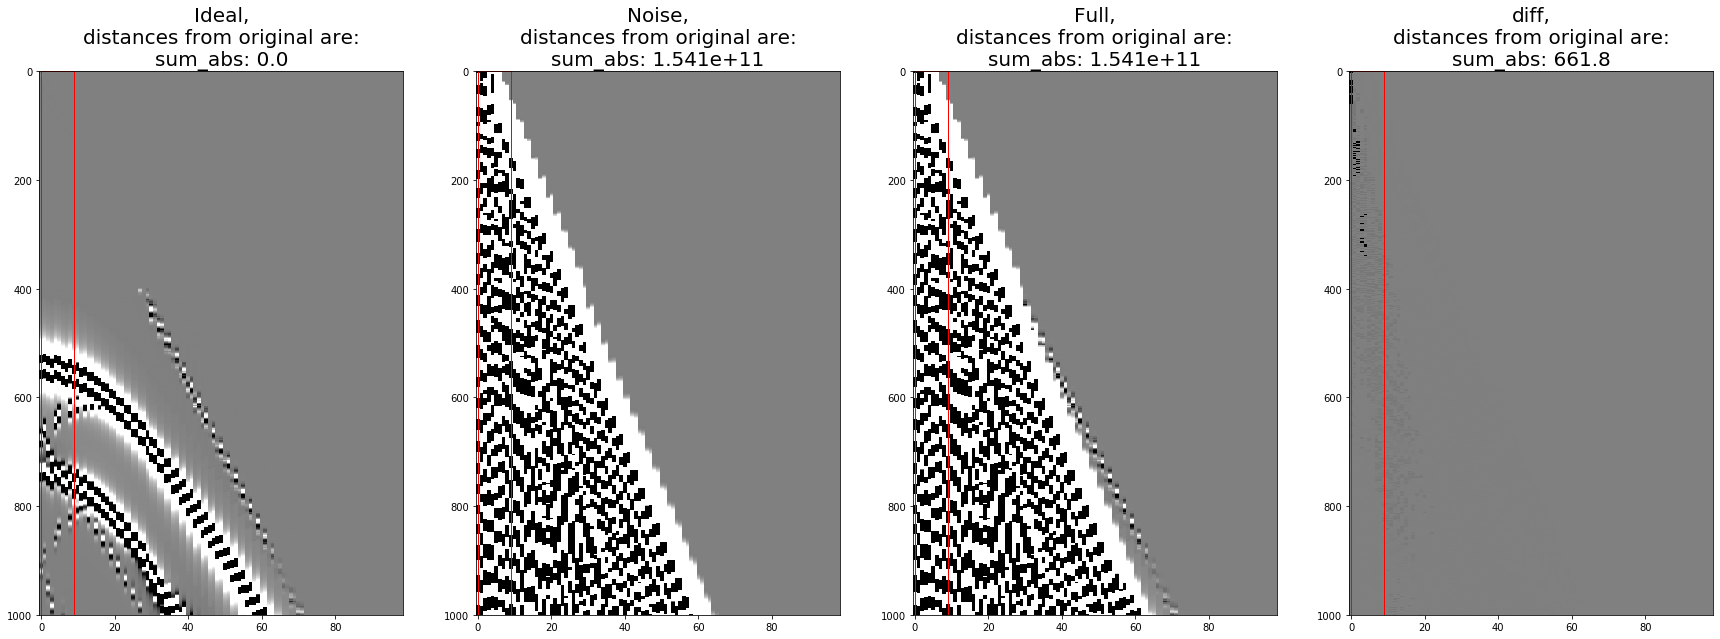

In [8]:
modifications = list(zip([ideal, noise, full, full - ideal - noise], ['Ideal', 'Noise', 'Full', 'diff']))

draw_modifications_dist(modifications, vmin=-cv, vmax=cv,  figsize=(30, 10), aspect='auto')

In [10]:
cv

0.06011068969964944

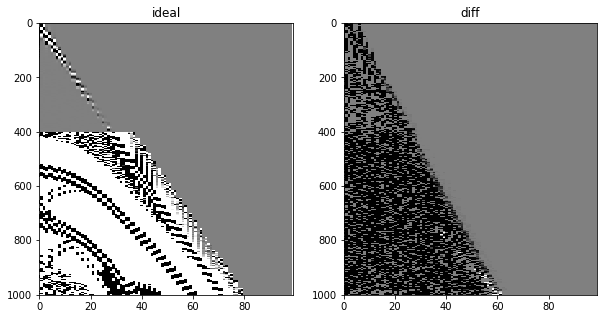

In [11]:
cv = 0.000001
seismic_plot((ideal, full - ideal - noise), names=('ideal', 'diff'),  figsize=(10, 5),
                   vmin=-cv, vmax=cv, cmap='gray')

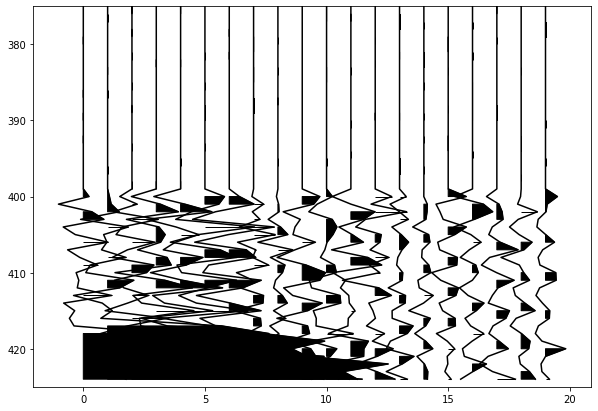

In [12]:
seismic_plot(ideal, wiggle=True, std=10000,
                   xlim=(0, 20), ylim=(375, 425), figsize=(10, 7))

In [40]:
diff = full - ideal - noise
np.sum(diff > 0), np.sum(diff == 0), np.sum(diff < 0)

(150, 73767, 25182)

In [41]:
diff.shape

(99, 1001)

In [42]:
np.sum(diff[:, 400:] > 0), np.sum(diff[:, 400:]  == 0), np.sum(diff[:, 400:]  < 0)

(150, 38293, 21056)

In [49]:
np.sum(full[80:] < 0)

0